# MCMC sampling diagnostics

In this notebook, we illustrate how to assess the quality of your MCMC samples, e.g. convergence and auto-correlation, in pyPESTO.

## The pipeline

First, we load the model and data to generate the MCMC samples from. Here, we show a toy example of a conversion reaction, loaded as a [PEtab](https://github.com/petab-dev/petab) problem.

In [6]:
# Imports

import logging

import numpy as np
import petab
import amici
import amici.plotting
import sys
import os
import importlib

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.sample as sample
import pypesto.visualize as visualize

# Captures diagnostic information to provide insights during the sampling process
# Log level = INFO means it will capture informational messages and errors
logger = logging.getLogger("pypesto.sample.diagnostics")
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

# Loading a PEtab problem configuration from the .yaml file
petab_problem = petab.Problem.from_yaml(
    "/SBML/PyPESTO/FRP/FRP_v1/FRP_v1.yaml"
)

# Imports loaded PEtab problem into pyPESTO to set up problem and prepare for parameter estimation
importer = pypesto.petab.PetabImporter(petab_problem)
problem = importer.create_problem()

Visualization table not available. Skipping.
Compiling amici model to folder /SBML/PyPESTO/FRP/amici_models/0.26.1/tmpd_c0sw0j.
2024-11-04 23:34:02.521 - amici.petab.sbml_import - INFO - Importing model ...
2024-11-04 23:34:02.521 - amici.petab.sbml_import - INFO - Validating PEtab problem ...
Visualization table not available. Skipping.
2024-11-04 23:34:02.536 - amici.petab.sbml_import - INFO - Model name is 'tmpd_c0sw0j'.
Writing model code to '/SBML/PyPESTO/FRP/amici_models/0.26.1/tmpd_c0sw0j'.


2024-11-04 23:34:02.538 - amici.petab.sbml_import - INFO - Species: 10
2024-11-04 23:34:02.539 - amici.petab.sbml_import - INFO - Global parameters: 9
2024-11-04 23:34:02.540 - amici.petab.sbml_import - INFO - Reactions: 15
2024-11-04 23:34:02.548 - amici.sbml_import - DEBUG - Finished validating SBML                    ++ (7.19E-04s)
2024-11-04 23:34:02.553 - amici.sbml_import - DEBUG - Finished converting SBML local parameters   ++ (1.97E-04s)
2024-11-04 23:34:02.554 - amici.sbml_import - DEBUG - Finished loading SBML                        + (1.05E-02s)
2024-11-04 23:34:02.563 - amici.petab.sbml_import - INFO - Observables: 2
2024-11-04 23:34:02.564 - amici.petab.sbml_import - INFO - Sigmas: 2
2024-11-04 23:34:02.566 - amici.petab.sbml_import - DEBUG - Adding output parameters to model: []
2024-11-04 23:34:02.568 - amici.petab.sbml_import - DEBUG - Adding initial assignments for ['A', 'B']
2024-11-04 23:34:02.572 - amici.petab.sbml_import - DEBUG - Fixed parameters are ['f', 'kd']
2

running build_ext
running AmiciBuildCMakeExtension
------------------------------ model_ext ------------------------------

==> Configuring:
$ cmake -S /SBML/PyPESTO/FRP/amici_models/0.26.1/tmpd_c0sw0j -B /SBML/PyPESTO/FRP/amici_models/0.26.1/tmpd_c0sw0j/build_model_ext -G Ninja -DCMAKE_MAKE_PROGRAM=/usr/local/bin/ninja -DCMAKE_BUILD_TYPE=Release -DCMAKE_INSTALL_PREFIX:PATH=/SBML/PyPESTO/FRP/amici_models/0.26.1/tmpd_c0sw0j/tmpd_c0sw0j -DCMAKE_VERBOSE_MAKEFILE=ON -DCMAKE_MODULE_PATH=/usr/local/lib/python3.10/dist-packages/amici/lib/cmake/SuiteSparse;/usr/local/lib/python3.10/dist-packages/amici/lib64/cmake/SuiteSparse -DKLU_ROOT=/usr/local/lib/python3.10/dist-packages/amici -DAMICI_PYTHON_BUILD_EXT_ONLY=ON -DPython3_EXECUTABLE=/usr/bin/python3

==> Building:
$ cmake --build /SBML/PyPESTO/FRP/amici_models/0.26.1/tmpd_c0sw0j/build_model_ext --config Release

==> Installing:
$ cmake --install /SBML/PyPESTO/FRP/amici_models/0.26.1/tmpd_c0sw0j/build_model_ext --config Release

-- The C compi

Create the sampler object, in this case we will use adaptive parallel tempering with 3 temperatures.

In [7]:
# AdaptiveParallelTemperingSampler is a sampler designed to handle complex posterior distributions
# Sampler creates 5 parallel chains that run simultaneously
# These chains exchange info periodically to improve exploration and allow for convergence

sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=5,
)

Initializing betas with "near-exponential decay".


First, we will initiate the MCMC chain at a "random" point in parameter space, e.g. $\theta_{start} = [3, -4]$

In [8]:
# Prevents large outputs from being displayed
#%%capture

# Total number of samples to be generated
n_samples = 10_000

# Runs the sampling process on the problem, using the specified sampler and initial guess
result = sample.sample(
    problem,
    n_samples=n_samples,            # Specifies the total number of samples across chains
    sampler=sampler,                # Provides AdaptiveParallelTemperingSampler from earlier
    x0=np.array([0, 0, 0, 0]),      # Specifies the initial parameter values for sampling process
    filename=None,
)

# Retrieves total time taken for the sampling process
elapsed_time = result.sample_result.time
print(f"Elapsed time: {round(elapsed_time,2)}")

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:13<00:00, 135.51it/s]
Elapsed time: 73.894260137


Elapsed time: 73.89


/usr/local/lib/python3.10/dist-packages/pypesto/visualize/sampling.py:1117: UserWarning: Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., `pypesto.sample.geweke_test`.
  nr_params, params_fval, theta_lb, theta_ub, param_names = get_data_to_plot(


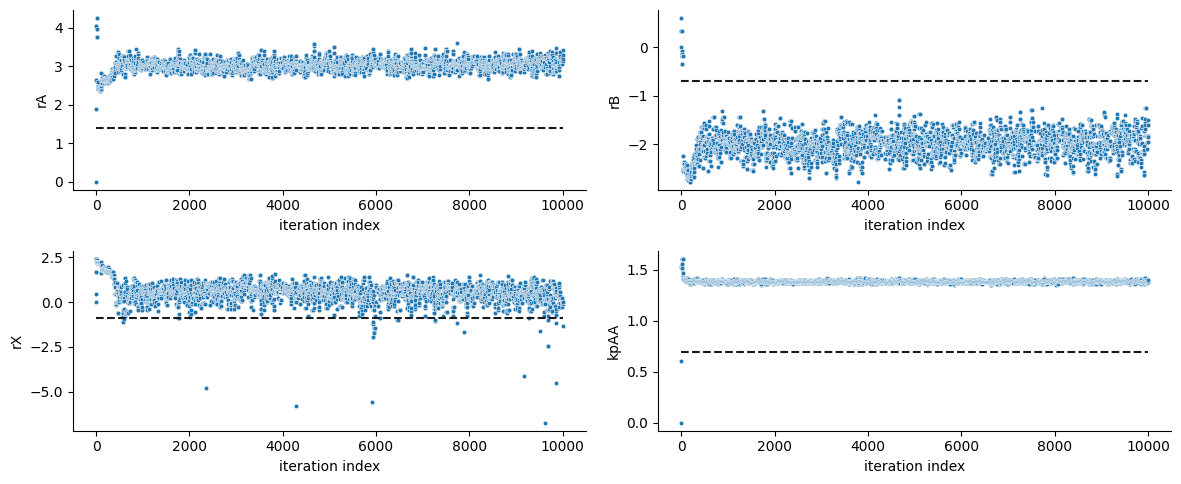

In [9]:
# Creates plots of the sampled parameter traces
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5)
)

# Defines the true parameter values
kpAA_true = 2.0
kpAB_true = 0.5
kpBA_true = 10.0
kpBB_true = 5.0

# Calculates ratios between true values
rA_true = kpAA_true / kpAB_true
rB_true = kpBB_true / kpBA_true
rX_true = kpAA_true / kpBB_true

# Plotting true values for reference with future parts
ax[0][0].plot([0, n_samples], np.log([rA_true, rA_true]), "k--")
ax[0][1].plot([0, n_samples], np.log([rB_true, rB_true]), "k--")
ax[1][0].plot([0, n_samples], np.log([rX_true, rX_true]), "k--")
ax[1][1].plot([0, n_samples], np.log([kpAA_true, kpAA_true]), "k--")

By visualizing the chains, we can see a warm up phase occurring until convergence of the chain is reached. This is commonly known as "burn in" phase and should be discarded. An automatic way to evaluate and find the index of the chain in which the warm up is finished can be done by using the Geweke test.

Geweke burn-in index: 5000
Geweke burn-in index: 5000
Geweke burn-in index: 5000
Geweke burn-in index: 5000
Geweke burn-in index: 5000


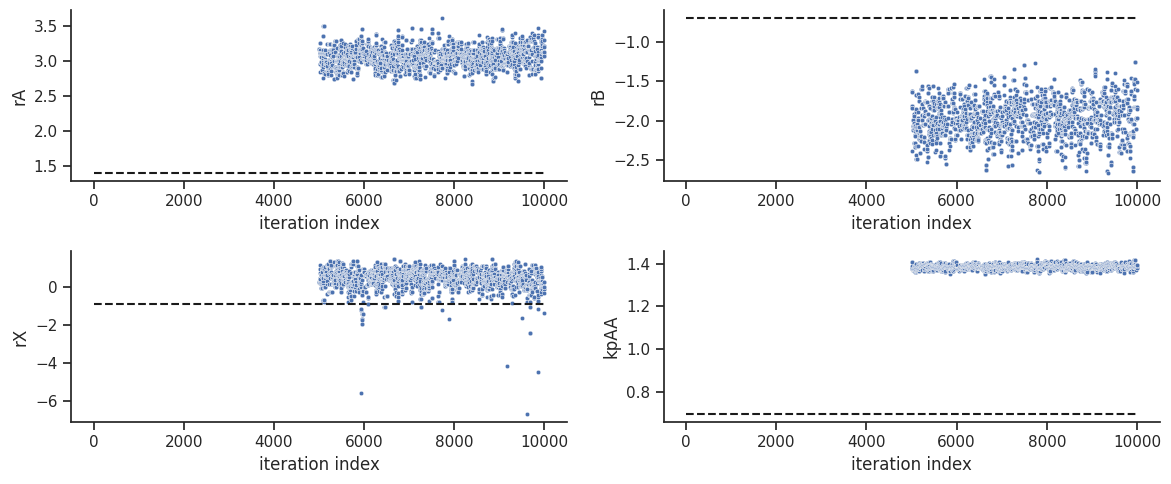

In [10]:
# Runs the Geweke test on result from the sampling process
# Convergence diagnostic test that checks if early and late parts of a MC sampling sequenece come from same distribution
# If segments show similar statistics, sampling chains have likely converged
sample.geweke_test(result=result)

# Generates trace plots of the sampled parameters from result
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5)
)

ax[0][0].plot([0, n_samples], np.log([rA_true, rA_true]), "k--")
ax[0][1].plot([0, n_samples], np.log([rB_true, rB_true]), "k--")
ax[1][0].plot([0, n_samples], np.log([rX_true, rX_true]), "k--")
ax[1][1].plot([0, n_samples], np.log([kpAA_true, kpAA_true]), "k--")

Text(0.5, 178.25, 'iteration index')

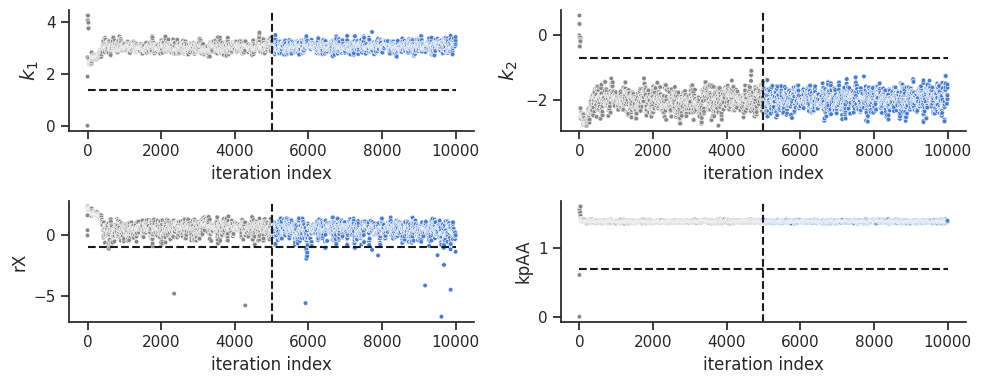

In [11]:
# Generates trace plots for the sampled parameters in result
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, full_trace=True, size=(10, 4)
)

# Adds horizontal dashed lines to represent the true values for each trace plot
ax[0][0].plot([0, n_samples], np.log([rA_true, rA_true]), "k--")
ax[0][1].plot([0, n_samples], np.log([rB_true, rB_true]), "k--")
ax[1][0].plot([0, n_samples], np.log([rX_true, rX_true]), "k--")
ax[1][1].plot([0, n_samples], np.log([kpAA_true, kpAA_true]), "k--")

# Customizing axis labels
ax[0][0].set_ylabel('$k_1$', fontsize=14)
ax[0][1].set_ylabel('$k_2$', fontsize=14)
ax[0][0].set_xlabel('iteration index', fontsize=12)
ax[0][1].set_xlabel('iteration index', fontsize=12)

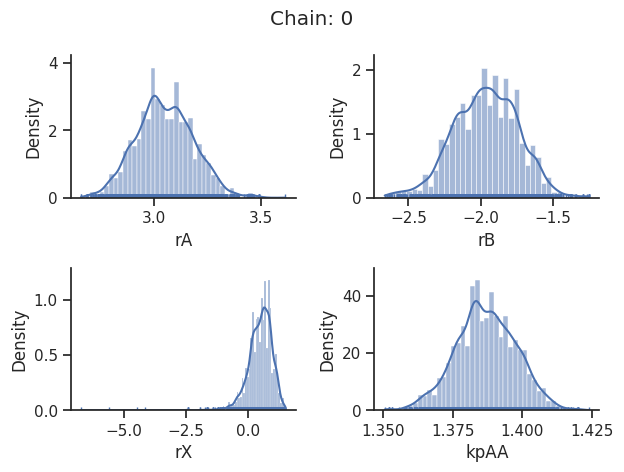

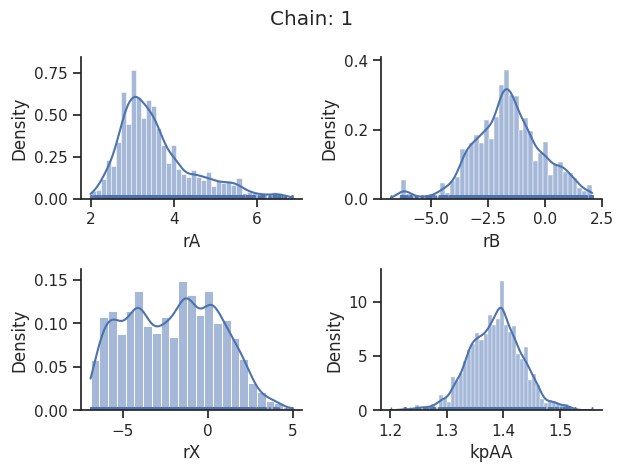

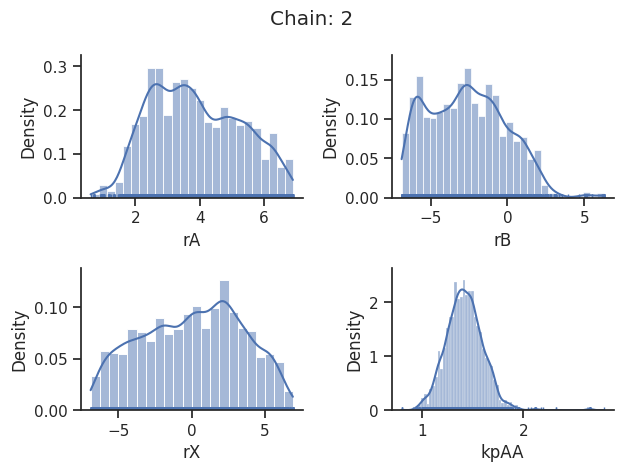

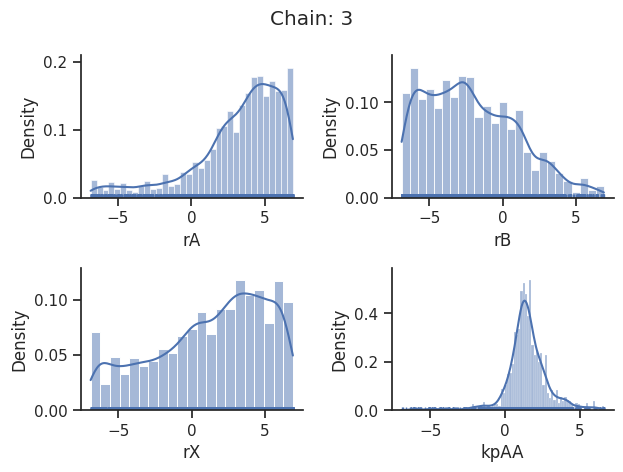

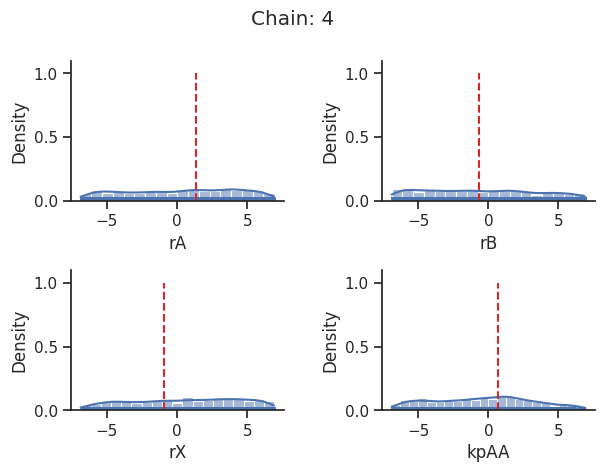

In [12]:
# Loops through each chain in the sampling result
# len(result.sample_result.betas) gives number of chains used in sampling
for i_chain in range(len(result.sample_result.betas)): 
    ax = visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}"       # Plots marginal densities for each parameter in the specified chain
    )

# Adds vertical dashed lines to represent the logarithm of the true parameter values
# For comparison against the sampled densities
ax[0][0].vlines(np.log(rA_true), 0, 1, color="tab:red", linestyle="--")
ax[0][1].vlines(np.log(rB_true), 0, 1, color="tab:red", linestyle="--")
ax[1][0].vlines(np.log(rX_true), 0, 1, color="tab:red", linestyle="--")
ax[1][1].vlines(np.log(kpAA_true, ), 0, 1, color="tab:red", linestyle="--")

One can calculate the effective sample size per computation time. We save the results in a variable to compare them later.

In [13]:
sample.effective_sample_size(result=result)
ess = result.sample_result.effective_sample_size
print(
    f"Effective sample size per computation time: {round(ess/elapsed_time,2)}"
)

Estimated chain autocorrelation: 13.718797725924587
Estimated chain autocorrelation: 13.718797725924587
Estimated chain autocorrelation: 13.718797725924587
Estimated chain autocorrelation: 13.718797725924587
Estimated chain autocorrelation: 13.718797725924587
Estimated effective sample size: 339.769598925299
Estimated effective sample size: 339.769598925299
Estimated effective sample size: 339.769598925299
Estimated effective sample size: 339.769598925299
Estimated effective sample size: 339.769598925299


Effective sample size per computation time: 4.6


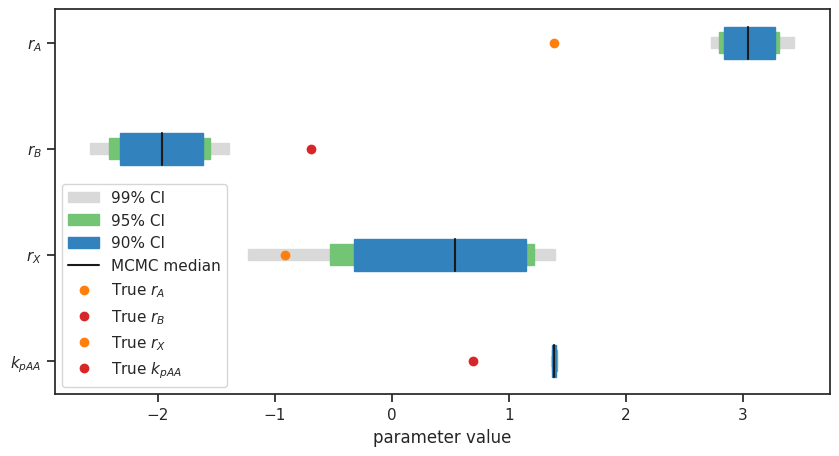

In [14]:
alpha = [99, 95, 90]
import matplotlib.pyplot as plt
ax = visualize.sampling_parameter_cis(result, alpha=alpha, size=(10, 5))
line1, = ax.plot([np.log(rA_true)], 0, 'o', color='tab:orange', label='True $r_{A}$')
line2, = ax.plot([np.log(rB_true)], 1, 'o', color='tab:red', label='True $r_{B}$')
line3, = ax.plot([np.log(rX_true)], 2, 'o', color='tab:orange', label='True $r_{X}$')
line4, = ax.plot([np.log(kpAA_true)], 3, 'o', color='tab:red', label='True $k_{pAA}$')
# ax.legend()
# Get existing legend handles and labels
handles, labels = ax.get_legend_handles_labels()

unique_handles_labels = list(dict(zip(labels, handles)).items())
unique_labels, unique_handles = zip(*unique_handles_labels)

# Update the legend with unique handles and labels
ax.legend(unique_handles, unique_labels)
ax.set_yticks([0,1,2,3],['$r_{A}$', '$r_{B}$', '$r_{X}$', '$k_{pAA}$'])
ax.set_xlabel('parameter value')
ax.set_ylabel('')
plt.show()
# ax.vlines(np.log([k1_true, k2_true]), 0, 1, color="k", linestyle="--")

Predictions can be performed by creating a parameter ensemble from the sample, then applying a predictor to the ensemble. The predictor requires a simulation tool. Here, [AMICI](https://github.com/AMICI-dev/AMICI) is used. First, the predictor is set up.

In [15]:
from pypesto.C import AMICI_STATUS, AMICI_T, AMICI_X, AMICI_Y
from pypesto.predict import AmiciPredictor


# This post_processor will transform the output of the simulation tool
# such that the output is compatible with the next steps.
def post_processor(amici_outputs, output_type, output_ids):
    outputs = [
        (
            amici_output[output_type]
            if amici_output[AMICI_STATUS] == 0
            else np.full((len(amici_output[AMICI_T]), len(output_ids)), np.nan)
        )
        for amici_output in amici_outputs
    ]
    return outputs


# Setup post-processors for both states and observables.
from functools import partial

amici_objective = result.problem.objective
state_ids = amici_objective.amici_model.getStateIds()
observable_ids = amici_objective.amici_model.getObservableIds()
post_processor_x = partial(
    post_processor,
    output_type=AMICI_X,
    output_ids=state_ids,
)
post_processor_y = partial(
    post_processor,
    output_type=AMICI_Y,
    output_ids=observable_ids,
)

# Create pyPESTO predictors for states and observables
predictor_x = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_x,
    output_ids=state_ids,
)
predictor_y = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_y,
    output_ids=observable_ids,
)

Next, the ensemble is created.

In [16]:
from pypesto.C import EnsembleType
from pypesto.ensemble import Ensemble

# corresponds to only the estimated parameters
x_names = result.problem.get_reduced_vector(result.problem.x_names)

# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    result,
    chain_slice=slice(
        None, None, 5
    ),  # Optional argument: only use every fifth vector in the chain.
    x_names=x_names,
    ensemble_type=EnsembleType.sample,
    lower_bound=result.problem.lb,
    upper_bound=result.problem.ub,
)

The predictor is then applied to the ensemble to generate predictions.

In [17]:
from pypesto.engine import MultiProcessEngine

engine = MultiProcessEngine()

ensemble_prediction = ensemble.predict(
    predictor_x, prediction_id=AMICI_X, engine=engine
)

Engine will use up to 8 processes (= CPU count).
100%|██████████| 8/8 [00:00<00:00, 14.44it/s]


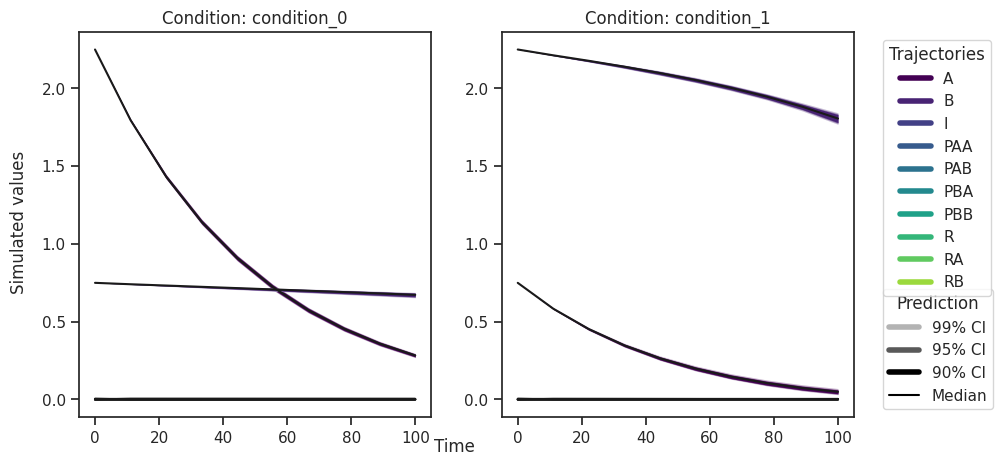

In [18]:
from pypesto.C import CONDITION, OUTPUT

credibility_interval_levels = [90, 95, 99]

ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10, 5),
    # labels={"A": "state_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=CONDITION,
    # condition_ids=["condition_0", "condition_1", "condition_2"],  # `None` for all conditions
    # output_ids=["A", "B"],  # `None` for all outputs
)

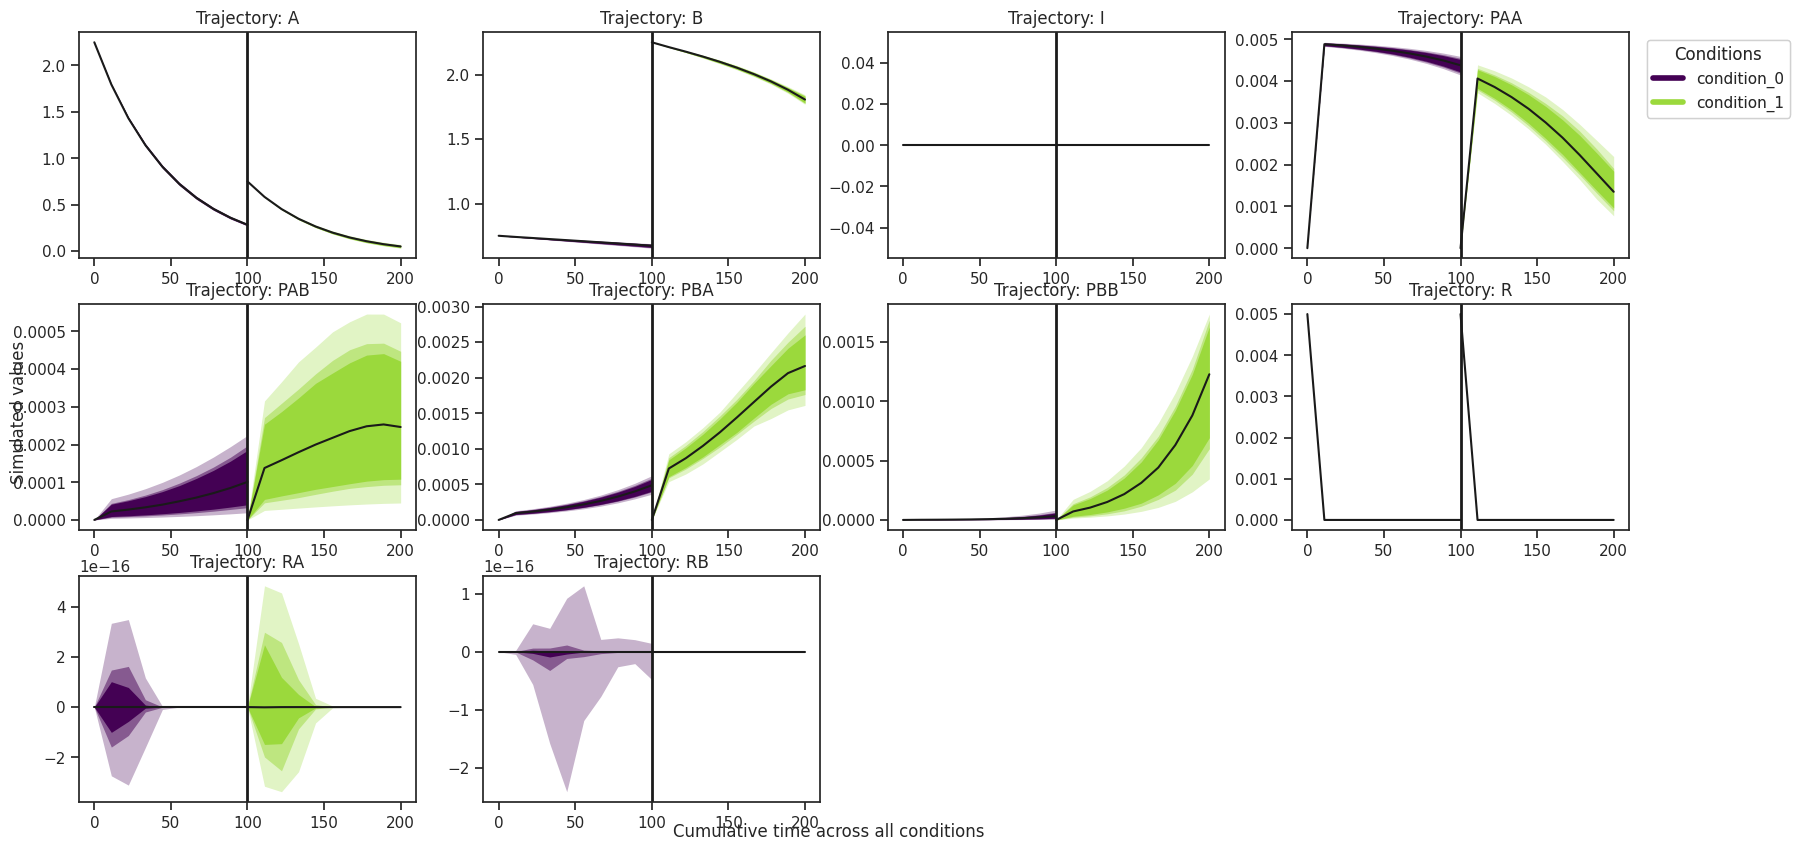

In [19]:
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(20, 10),
    # labels={"A": "obs_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=OUTPUT,
)

In [20]:
mdf = petab_problem.measurement_df
# Create a custom objective with new output timepoints.
num_conditions=3
timepoints = [np.linspace(0, 200, 100) for i in range(num_conditions)]
amici_objective_custom = amici_objective.set_custom_timepoints(
    timepoints=timepoints
)

# Create an observable predictor with the custom objective.
predictor_y_custom = AmiciPredictor(
    amici_objective_custom,
    post_processor=post_processor_y,
    output_ids=observable_ids,
    condition_ids=[edata.id for edata in amici_objective_custom.edatas],
)

# Predict then plot.
ensemble_prediction = ensemble.predict(
    predictor_y_custom, prediction_id=AMICI_Y, engine=engine
)

ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    groupby=CONDITION,
    measurement_df=mdf,
    
)
import matplotlib.pyplot as plt
# ax[0][0].set_title('')
# ax[1][0].set_title('')
# ax[0][1].set_title('')
# ax[1][1].set_title('')
# ax[0][0].set_ylim([-0.1, 2.1])
# ax[1][0].set_ylim([-0.1, 2.1])
# ax[0][1].set_ylim([-0.1, 2.1])
# ax[1][1].set_ylim([-0.1, 2.1])

plt.show()

ValueError: The number of condition-specific timepoints `timepoints` does not match the number of experimental conditions.
Number of provided timepoints: 3. Number of experimental conditions: 2.

In [ ]:
petab_problem.measurement_df

: 

Predictions are stored in `ensemble_prediction.prediction_summary`.

### Finding parameter point estimates
Commonly, as a first step, optimization is performed, in order to find good parameter point estimates.

In [ ]:
res = optimize.minimize(problem, n_starts=10, filename=None)

: 

By passing the result object to the function, the previously found global optimum is used as starting point for the MCMC sampling.

In [ ]:
%%capture
res = sample.sample(
    problem, n_samples=10000, sampler=sampler, result=res, filename=None
)
elapsed_time = res.sample_result.time
print("Elapsed time: " + str(round(elapsed_time, 2)))

: 

When the sampling is finished, we can analyse our results. pyPESTO provides functions to analyse both the sampling process as well as the obtained sampling result. Visualizing the traces e.g. allows to detect burn-in phases, or fine-tune hyperparameters. First, the parameter trajectories  can be visualized:

In [ ]:
ax = visualize.sampling_parameter_traces(
    res, use_problem_bounds=False, size=(12, 5)
)
# ax[0][0].plot([0, 1000], np.log([k1_true, k1_true]), "k--")
# ax[0][1].plot([0, 1000], np.log([k2_true, k2_true]), "k--")

: 

By visual inspection one can see, that the chain is already converged from the start. This is already showing the benefit of initiating the chain at the optimal parameter vector. However, this may not be always the case.

In [ ]:
sample.geweke_test(result=res)
ax = visualize.sampling_parameter_traces(
    res, use_problem_bounds=False, size=(12, 5)
)
# ax[0][0].plot([0, 1000], np.log([k1_true, k1_true]), "k--")
# ax[0][1].plot([0, 1000], np.log([k2_true, k2_true]), "k--")

: 

In [ ]:
sample.effective_sample_size(result=res)
ess = res.sample_result.effective_sample_size
print(
    f"Effective sample size per computation time: {round(ess/elapsed_time,2)}"
)

: 

In [ ]:
percentiles = [99, 95, 90]
ax = visualize.sampling_parameter_cis(res, alpha=percentiles, size=(10, 5))

: 

In [ ]:
# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    res,
    x_names=x_names,
    chain_slice=slice(None, None, 5),
    ensemble_type=EnsembleType.sample,
    lower_bound=res.problem.lb,
    upper_bound=res.problem.ub,
)

ensemble_prediction = ensemble.predict(
    predictor_y, prediction_id=AMICI_Y, engine=engine
)

: 

In [ ]:
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10, 5),
    labels={"A": "obs_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=CONDITION,
)

: 

In [ ]:
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10, 5),
    # labels={"A": "obs_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=OUTPUT,
    reverse_opacities=True,
)

: 

Custom timepoints can also be specified, either for each condition
- `amici_objective.set_custom_timepoints(..., timepoints=...)`

or for all conditions
- `amici_objective.set_custom_timepoints(..., timepoints_global=...)`.

Plotting of measurement data (`petab_problem.measurement_df`) is also demonstrated here, which requires correct IDs in the `AmiciPredictor` that align with the observable and condition IDs in the measurement data.

In [ ]:

# Create a custom objective with new output timepoints.
timepoints = [np.linspace(0, 3, 100), np.linspace(0, 3, 100), np.linspace(0, 3, 10), np.linspace(0, 3, 10)]
amici_objective_custom = amici_objective.set_custom_timepoints(
    timepoints=timepoints
)

# Create an observable predictor with the custom objective.
predictor_y_custom = AmiciPredictor(
    amici_objective_custom,
    post_processor=post_processor_y,
    output_ids=observable_ids,
    condition_ids=[edata.id for edata in amici_objective_custom.edatas],
)

# Predict then plot.
ensemble_prediction = ensemble.predict(
    predictor_y_custom, prediction_id=AMICI_Y, engine=engine
)

ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    groupby=CONDITION,
    measurement_df=petab_problem.measurement_df,
    
)
import matplotlib.pyplot as plt
ax[0][0].set_title('')
ax[0][0].set_ylim([-0.1, 2.1])
ax[1][0].set_ylim([-0.1, 2.1])
ax[0][1].set_ylim([-0.1, 2.1])
plt.show()

: 

In [ ]:
mdf = petab_problem.measurement_df
mdf.head()

: 

In [ ]:
mdf[mdf['simulationConditionId'] == 'c_1']

observables = mdf['observableId'].unique()
conditions = mdf['simulationConditionId'].unique()
n_obs = len(observables)
n_conditions = len(conditions)
colors = []


fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=300)
axs = axs.flatten()
print(axs)
for i, condition in enumerate(conditions):
    for j, observable in enumerate(observables):
        data = mdf[(mdf['observableId'] == observable) & (mdf['simulationConditionId'] == condition)]
        axs[i].plot(data['time'], data['measurement'], 'o-', label=f'{observable}')
    axs[i].set_title(f'{condition}')
    axs[i].set_xlabel('time')
    axs[i].set_ylim([-0.1, 2.1])
    axs[i].legend()
plt.tight_layout()

: 

In [ ]:
mdf

: 

In [ ]:
mdf = petab_problem.measurement_df
c0df = mdf[mdf["simulationConditionId"] == "c_1"]
c1df = mdf[mdf["simulationConditionId"] == "c_2"]

: 

: 

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(c0df["time"], c0df["measurement"], '-o', color='tab:blue')
ax[1].plot(c1df["time"], c1df["measurement"], '-o', color='tab:orange')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')
ax[0].legend(['c0'])
ax[1].legend(['c1'])
ax[0].set_ylabel('Exp data: Concentration of A (M)')
ax[1].set_ylabel('Exp data: Concentration of A (M)')

ax[0].set_title('Condition 0')
ax[1].set_title('Condition 1')
ax[0].set_ylim([0, 3.0])
ax[1].set_ylim([0, 3.0])

: 

: 

: 

: 